# ЗАДАНИЕ 7. ПОСТРОЕНИЕ МОДЕЛИ АВТОРЕГРЕССИИ

In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from math import sqrt
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import scipy.stats
from scipy.stats import t as student
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg, ar_select_order 
import warnings

In [2]:
os.chdir("C:/Users/HP/Documents/analysis/TS/data/")

In [3]:
data = pd.read_excel('data.xls', sheet_name='Material 3')
data.head()

,Unnamed: 0,Unnamed: 1,Рыночные цены на материал 3 (руб.),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49
0,NaN,NaN,2007-01-01 00:00:00,2007-02-01 00:00:00,2007-03-01 00:00:00,2007-04-01 00:00:00,2007-05-01 00:00:00,2007-06-01 00:00:00,2007-07-01 00:00:00,2007-08-01 00:00:00,...,2010-03-01 00:00:00,2010-04-01 00:00:00,2010-05-01 00:00:00,2010-06-01 00:00:00,2010-07-01 00:00:00,2010-08-01 00:00:00,2010-09-01 00:00:00,2010-10-01 00:00:00,2010-11-01 00:00:00,2010-12-01 00:00:00
1,№ организации,1.0,10.07,10.04,10.05,10.05,10.03,10.03,10.06,10.03,...,10.18,10.18,10.16,10.17,10.14,10.16,10.12,10.14,10.12,10.15
2,NaN,2.0,10,10.25,10.23,10.39,10.22,10.16,9.99,9.91,...,8.84,8.78,8.7,8.55,8.61,8.85,8.77,8.55,8.44,8.21
3,NaN,3.0,78.79,78.93,78.81,78.7,78.63,78.76,78.6,78.7,...,79.02,79.12,79.09,79.16,79.28,79.1,79.22,79.33,79.09,79.09
4,NaN,4.0,85.22,85.34,85.29,85.38,85.6,85.46,85.5,85.27,...,86.25,86.43,86.22,86.11,86.12,86.17,86.35,86.53,86.33,86.37


In [4]:
dates = data.loc[data.index == 0].values[0, 2:]
val = data.loc[data.index == 1].values[0, 2:]

In [5]:
data={"Date": dates, "Value": val}

In [6]:
my_data = pd.DataFrame(data)
my_data.head()

,Date,Value
0,2007-01-01,10.07
1,2007-02-01,10.04
2,2007-03-01,10.05
3,2007-04-01,10.05
4,2007-05-01,10.03


In [7]:
my_data=my_data.set_index('Date')
my_data.head()

,Value
Date,
2007-01-01,10.07
2007-02-01,10.04
2007-03-01,10.05
2007-04-01,10.05
2007-05-01,10.03


In [8]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Value   48 non-null     object
dtypes: object(1)
memory usage: 768.0+ bytes


In [9]:
my_data.Value=my_data.Value.astype(float)

In [10]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2007-01-01 to 2010-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


In [11]:
series=my_data.squeeze()
type(series)

pandas.core.series.Series

<AxesSubplot:xlabel='Date'>

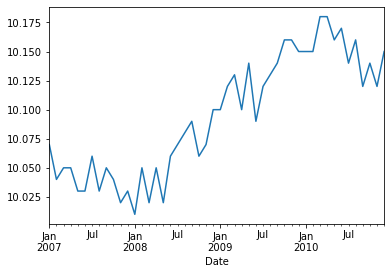

In [12]:
series.plot()

In [13]:
max_tau=int(len(series)/4)
max_tau

12

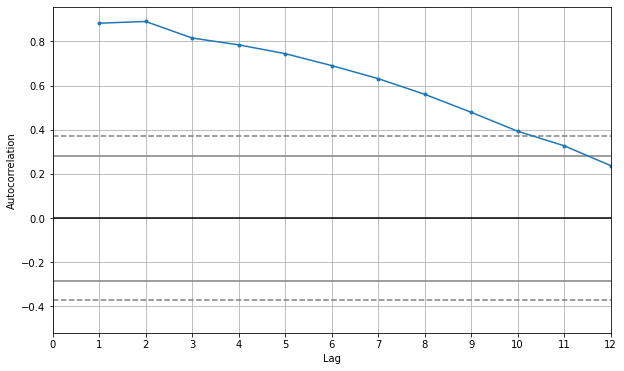

In [14]:
fig, ax = plt.subplots(figsize = (10, 6))

autocorrelation_plot(series, ax = ax, marker = '.')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlim(0, max_tau)

plt.show()

In [15]:
for i in range(1,max_tau+1):
    if series.autocorr(lag=i)>=0.8 or series.autocorr(lag=i)<=-0.8:
        print('tau=',i,'r=',series.autocorr(lag=i))

tau= 1 r= 0.8959886302192371
tau= 2 r= 0.9190976529054086
tau= 3 r= 0.8593969349232327
tau= 4 r= 0.8398604496481589
tau= 5 r= 0.8369255995982671
tau= 6 r= 0.8104791098026918


In [16]:
series.autocorr(lag=7)

0.781485822206191

In [17]:
# create lag features
temps = pd.DataFrame(series.values)
dataframe = pd.concat([temps.shift(6), temps.shift(5), temps.shift(4), temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-6', 't-5', 't-4', 't-3', 't-2', 't-1', 't']
print(dataframe.head(10))

     t-6    t-5    t-4    t-3    t-2    t-1      t
0    NaN    NaN    NaN    NaN    NaN    NaN  10.07
1    NaN    NaN    NaN    NaN    NaN  10.07  10.04
2    NaN    NaN    NaN    NaN  10.07  10.04  10.05
3    NaN    NaN    NaN  10.07  10.04  10.05  10.05
4    NaN    NaN  10.07  10.04  10.05  10.05  10.03
5    NaN  10.07  10.04  10.05  10.05  10.03  10.03
6  10.07  10.04  10.05  10.05  10.03  10.03  10.06
7  10.04  10.05  10.05  10.03  10.03  10.06  10.03
8  10.05  10.05  10.03  10.03  10.06  10.03  10.05
9  10.05  10.03  10.03  10.06  10.03  10.05  10.04


In [18]:
array = dataframe.values
# separate array into input and output components
x_train = array[6:36,0:6]
y_train = array[6:36,6]
x_test = array[36:48,0:6]
y_test= array[36:48,6]

In [19]:
len(x_train),len(y_train)

(30, 30)

In [20]:
len(x_test),len(y_test)

(12, 12)

In [21]:
model = LinearRegression().fit(x_train, y_train)
model

LinearRegression()

In [22]:
model.intercept_

-1.1305838135582906

In [23]:
model.coef_

array([ 0.28957294,  0.30568777, -0.33216294, -0.06657351,  0.67201834,
        0.24478978])

In [24]:
# Расчетные значения по модели на тестовом наборе
y_pred = model.predict(x_test) 
y_pred

array([10.16431481, 10.15690398, 10.1665792 , 10.18303598, 10.20013965,
       10.19035092, 10.16939356, 10.17927216, 10.17867211, 10.17488271,
       10.15879661, 10.15708596])

In [25]:
MSE = mean_squared_error(y_test, y_pred)
print('MSE: %f' % MSE)

MSE: 0.000826


In [26]:
array = dataframe.values
# separate array into input and output components
x_train = array[6:36,0:6]
y_train = array[6:36,6]
x_test = array[36:48,0:6]
y_test= array[36:48,6]

In [27]:
x = array[6:48,0:6]
y = array[6:48,6]

In [28]:
len(x),len(y)

(42, 42)

In [29]:
model = LinearRegression().fit(x, y)
model

LinearRegression()

In [30]:
model.intercept_

0.5453373690949554

In [31]:
model.coef_

array([ 0.07860707,  0.25185438, -0.24411278, -0.1826131 ,  0.68145948,
        0.36131217])

In [32]:
# Расчетные значения по модели на всем наборе
y_pred = model.predict(x) 
y_pred

array([10.03593308, 10.05058503, 10.06585778, 10.04212476, 10.04872369,
       10.04590961, 10.02764   , 10.03600061, 10.03893363, 10.05074062,
       10.03966034, 10.04072762, 10.04508335, 10.06969851, 10.08534251,
       10.07898216, 10.07840609, 10.062971  , 10.08696684, 10.11621249,
       10.10874965, 10.11882891, 10.11949358, 10.10915211, 10.12641923,
       10.10729517, 10.12394866, 10.14881958, 10.14426247, 10.15724968,
       10.15241992, 10.14402769, 10.15167698, 10.16652961, 10.18445485,
       10.17096415, 10.15362469, 10.16080782, 10.15300461, 10.15018149,
       10.13476688, 10.13682254])

In [33]:
R2 = r2_score(y, y_pred)
print('R2: %f' % R2)

R2: 0.879418


In [34]:
MAE = mean_absolute_error(y, y_pred)
print('MAE: %f' % MAE)

MAE: 0.015211


In [35]:
MSE = mean_squared_error(y, y_pred)
print('MSE: %f' % MSE)

MSE: 0.000308


In [36]:
# calculate root mean squared error
RMSE = sqrt(MSE)
print('RMSE: %f' % RMSE)

RMSE: 0.017542


In [37]:
y=my_data.Value

In [38]:
len(y[6:48])

42

In [39]:
y=y[6:48]

In [40]:
my_data['Error']=y-y_pred
my_data.head(10)

,Value,Error
Date,,
2007-01-01,10.07,NaN
2007-02-01,10.04,NaN
2007-03-01,10.05,NaN
2007-04-01,10.05,NaN
2007-05-01,10.03,NaN
2007-06-01,10.03,NaN
2007-07-01,10.06,0.024067
2007-08-01,10.03,-0.020585
2007-09-01,10.05,-0.015858


In [41]:
err=my_data['Error'][6:48]
err.head()

Date
2007-07-01    0.024067
2007-08-01   -0.020585
2007-09-01   -0.015858
2007-10-01   -0.002125
2007-11-01   -0.028724
Name: Error, dtype: float64

<AxesSubplot:xlabel='Date'>

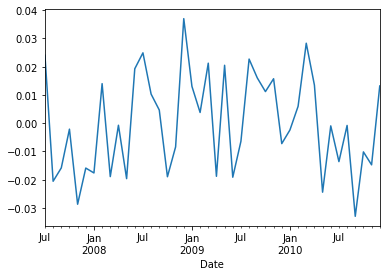

In [42]:
err.plot()

In [43]:
err.describe()

count    4.200000e+01
mean     9.304726e-16
std      1.775466e-02
min     -3.300461e-02
25%     -1.589665e-02
50%     -8.859810e-04
75%      1.386714e-02
max      3.702900e-02
Name: Error, dtype: float64

<AxesSubplot:>

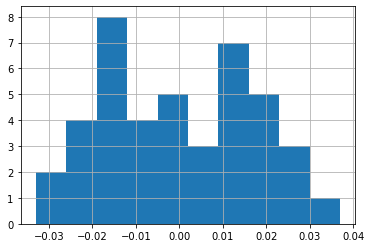

In [44]:
err.hist()

<AxesSubplot:ylabel='Density'>

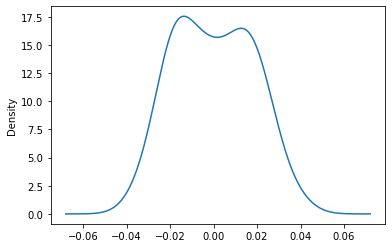

In [45]:
err.plot(kind='kde')

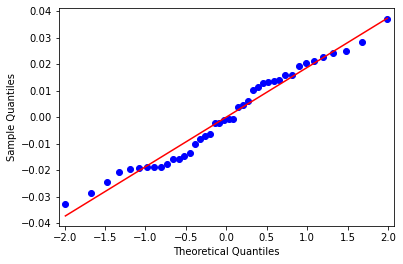

In [46]:
qqplot(err, line='r')
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

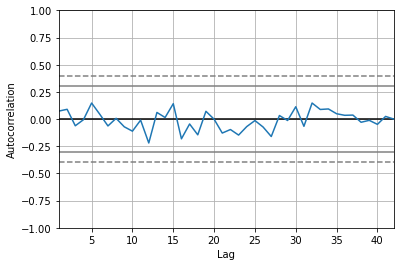

In [47]:
autocorrelation_plot(err)

<p><a name="Intervals"></a></p>

# Построение интервального прогноза

$$\frac{\hat{Y_i}-Y_i}{\sigma} \sim T(n) $$ 
где $$\sigma^2 = \frac{\sum_{i=1}^{n}(Y_i-\hat{Y_i})^2}{n-1} $$
-выборочная дисперсия
$$ P(-T_{n,\alpha} < \frac{\hat{Y_i}-Y_i}{\sigma} < T_{n,\alpha} ) = \alpha $$
$$ \left (\hat{Y_i} -T_{n,\alpha}\cdot \sigma \leq Y_i \leq \hat{Y_i} +T_{n,\alpha}\cdot \sigma \right ) $$

In [48]:
sigma=scipy.stats.sem(y)
sigma

0.00788945595667382

In [49]:
confidence=0.95
tstu=scipy.stats.t.ppf((1 + confidence) / 2., len(y)-1)
tstu

2.0195409639828936

In [50]:
x_new=x_test
x_new

array([[10.12, 10.13, 10.14, 10.16, 10.16, 10.15],
       [10.13, 10.14, 10.16, 10.16, 10.15, 10.15],
       [10.14, 10.16, 10.16, 10.15, 10.15, 10.15],
       [10.16, 10.16, 10.15, 10.15, 10.15, 10.18],
       [10.16, 10.15, 10.15, 10.15, 10.18, 10.18],
       [10.15, 10.15, 10.15, 10.18, 10.18, 10.16],
       [10.15, 10.15, 10.18, 10.18, 10.16, 10.17],
       [10.15, 10.18, 10.18, 10.16, 10.17, 10.14],
       [10.18, 10.18, 10.16, 10.17, 10.14, 10.16],
       [10.18, 10.16, 10.17, 10.14, 10.16, 10.12],
       [10.16, 10.17, 10.14, 10.16, 10.12, 10.14],
       [10.17, 10.14, 10.16, 10.12, 10.14, 10.12]])

In [51]:
# Прогнозные значения по модели
y_new = model.predict(x_new) 
y_new

array([10.15241992, 10.14402769, 10.15167698, 10.16652961, 10.18445485,
       10.17096415, 10.15362469, 10.16080782, 10.15300461, 10.15018149,
       10.13476688, 10.13682254])

In [52]:
y_up=y_new+tstu*sigma
y_up

array([10.168353  , 10.15996077, 10.16761006, 10.18246269, 10.20038793,
       10.18689722, 10.16955777, 10.1767409 , 10.16893769, 10.16611457,
       10.15069996, 10.15275561])

In [53]:
y_down=y_new-tstu*sigma
y_down

array([10.13648684, 10.12809461, 10.1357439 , 10.15059653, 10.16852177,
       10.15503107, 10.13769161, 10.14487474, 10.13707153, 10.13424841,
       10.1188338 , 10.12088946])

In [54]:
t = np.arange(1, len(y) + 1)
t

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42])

In [55]:
t_new = np.arange(len(y) + 1,len(y)+13)
t_new=t_new.reshape(-1,1)
t_new

array([[43],
       [44],
       [45],
       [46],
       [47],
       [48],
       [49],
       [50],
       [51],
       [52],
       [53],
       [54]])

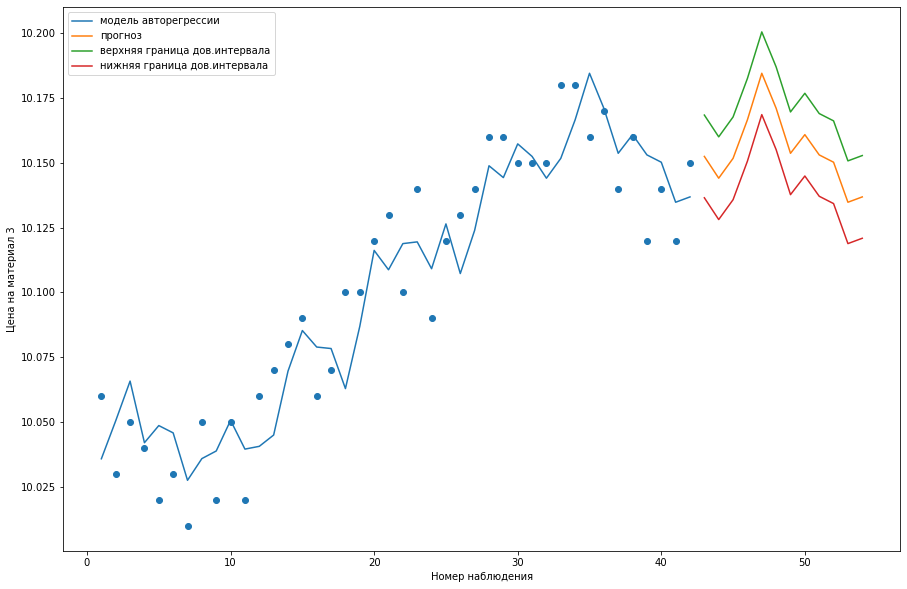

In [56]:
plt.figure(figsize=[15,10])

plt.scatter(t, y)

plt.plot(t,y_pred)
plt.plot(t_new,y_new)
plt.plot(t_new,y_up)
plt.plot(t_new,y_down)

plt.xlabel("Номер наблюдения")
plt.ylabel("Цена на материал 3")
plt.legend(['модель авторегрессии','прогноз','верхняя граница дов.интервала' ,\
            'нижняя граница дов.интервала'])

plt.show()

## Использование функции AutoReg

https://stackoverflow.com/questions/67236144/how-does-statsmodels-calculate-in-sample-predictions-in-ar-models/67258872#67258872

https://question-it.com/questions/2740330/znachenie-nachalnyh-konechnyh-parametrov-modelej-statistiki-autoregpredict

Coefficients: [-1.13058381  0.24478978  0.67201834 -0.06657351 -0.33216294  0.30568777
  0.28957294]
predicted=10.164315, expected=10.150000
predicted=10.160408, expected=10.150000
predicted=10.178747, expected=10.180000
predicted=10.188771, expected=10.180000
predicted=10.195997, expected=10.160000
predicted=10.206059, expected=10.170000
predicted=10.209570, expected=10.140000
predicted=10.217855, expected=10.160000
predicted=10.227548, expected=10.120000
predicted=10.237024, expected=10.140000
predicted=10.249307, expected=10.120000
predicted=10.259272, expected=10.150000
Test RMSE: 0.071


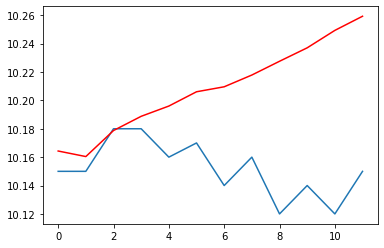

In [80]:
# create and evaluate a static autoregressive model
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
model = AutoReg(train, lags=6,old_names=False)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Имитируем пересчет значений по модели при поступлении каждого нового наблюдения. Расчет ведется на основе найденных в ходе обучения коэффициентов и последних наблюдений в количестве, равном лагу.

predicted=10.164315, expected=10.150000
predicted=10.156904, expected=10.150000
predicted=10.166579, expected=10.180000
predicted=10.183036, expected=10.180000
predicted=10.200140, expected=10.160000
predicted=10.190351, expected=10.170000
predicted=10.169394, expected=10.140000
predicted=10.179272, expected=10.160000
predicted=10.178672, expected=10.120000
predicted=10.174883, expected=10.140000
predicted=10.158797, expected=10.120000
predicted=10.157086, expected=10.150000
Test RMSE: 0.029


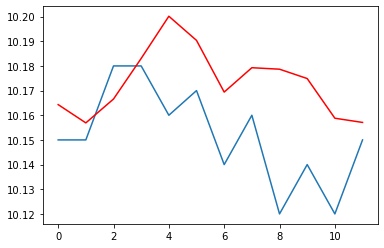

In [79]:
# create and evaluate an updated autoregressive model
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 6
model = AutoReg(train, lags=6,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## Grid Search AR Model Hyperparameters

In [59]:
# grid search AR parameter for time series
def evaluate_ar_model(X, ar_order):
	# prepare training dataset
	train_size = 36
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = AutoReg(history, lags=ar_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate p values for an AR model
def evaluate_models(dataset, p_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
            rmse = evaluate_ar_model(dataset, p)
            if rmse < best_score:
                best_score, best_cfg = rmse, p
            print('ARIMA%s RMSE=%.3f' % (p,rmse))
	print('Best AR%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = [0, 1, 2, 4, 6]
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values)

ARIMA0 RMSE=0.069
ARIMA1 RMSE=0.023
ARIMA2 RMSE=0.018
ARIMA4 RMSE=0.019
ARIMA6 RMSE=0.022
Best AR2 RMSE=0.018


In [60]:
modelp = ar_select_order(train, maxlag=max_tau)
modelp.ar_lags

array([1, 2])

Оптимальная задержка p составляет 2.

Coefficients: [-0.15743569  0.41955524  0.59655133]
predicted=10.162012, expected=10.150000
predicted=10.161086, expected=10.150000
predicted=10.167863, expected=10.180000
predicted=10.170154, expected=10.180000
predicted=10.175158, expected=10.160000
predicted=10.178624, expected=10.170000
predicted=10.183063, expected=10.140000
predicted=10.186993, expected=10.160000
predicted=10.191291, expected=10.120000
predicted=10.195438, expected=10.140000
predicted=10.199742, expected=10.120000
predicted=10.204022, expected=10.150000
Test RMSE: 0.042


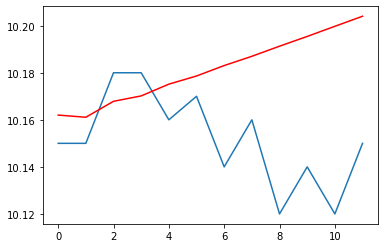

In [61]:
# create and evaluate a static autoregressive model
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
model = AutoReg(train, lags=modelp.ar_lags)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

predicted=10.162012, expected=10.150000
predicted=10.156046, expected=10.150000
predicted=10.156046, expected=10.180000
predicted=10.168633, expected=10.180000
predicted=10.186529, expected=10.160000
predicted=10.178138, expected=10.170000
predicted=10.170403, expected=10.140000
predicted=10.163782, expected=10.160000
predicted=10.154276, expected=10.120000
predicted=10.149425, expected=10.140000
predicted=10.133954, expected=10.120000
predicted=10.137494, expected=10.150000
Test RMSE: 0.019


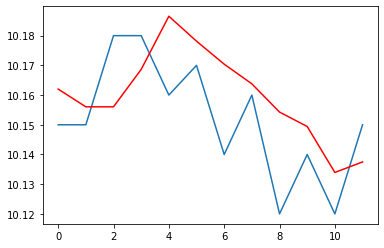

In [62]:
# create and evaluate an updated autoregressive model
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 2
model = AutoReg(train, lags=2,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Метод ar_select_order также может искать модели, которые не включают все задержки, если вы установите glob=True. При этом данная функция возвращает модель, которая считается оптимальной с использованием информационных критериев. В частности, по умолчанию используется BIC (Bayesian Information Criterion, байесовский информационный критерий). Обычно мы выбираем модель с наименьшим BIC.

In [66]:
modelp = ar_select_order(train, maxlag=max_tau, ic="aic", glob=True)
modelp.ar_lags

array([ 2,  4,  5,  6, 12])

In [67]:
model=AutoReg(endog=train, lags=[2,4,5,6,12])
res = model.fit()
res.aic

-7.726017433110175

In [68]:
model=AutoReg(endog=train, lags=modelp.ar_lags)
res = model.fit()
res.aic

-7.726017433110175

In [74]:
modelp = ar_select_order(train, maxlag=max_tau, glob=True)
modelp.ar_lags

array([2, 5])

In [75]:
modelp = ar_select_order(train, maxlag=max_tau, ic="bic", glob=True)
modelp.ar_lags

array([2, 5])

In [76]:
model=AutoReg(endog=train, lags=modelp.ar_lags)
res = model.fit()
res.bic

-7.417259563193276

Coefficients: [-0.81924355  0.74785224  0.33450762]
predicted=10.167497, expected=10.150000
predicted=10.163364, expected=10.150000
predicted=10.183140, expected=10.180000
predicted=10.180048, expected=10.180000
predicted=10.191493, expected=10.160000
predicted=10.195034, expected=10.170000
predicted=10.202210, expected=10.140000
predicted=10.211473, expected=10.160000
predicted=10.215806, expected=10.120000
predicted=10.226561, expected=10.140000
predicted=10.230986, expected=10.120000
predicted=10.241430, expected=10.150000
Test RMSE: 0.062


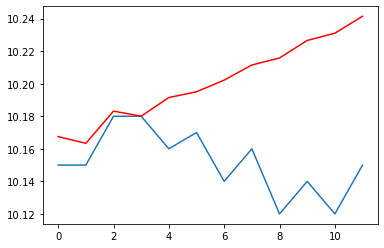

In [77]:
# create and evaluate a static autoregressive model
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
model = AutoReg(train, lags=modelp.ar_lags)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Имитируем пересчет значений по модели при поступлении каждого нового наблюдения. Расчет ведется на основе найденных в ходе обучения коэффициентов и последних наблюдений в количестве, равном лагу.

predicted=10.170054, expected=10.150000
predicted=10.166709, expected=10.150000
predicted=10.166709, expected=10.180000
predicted=10.189145, expected=10.180000
predicted=10.199180, expected=10.160000
predicted=10.184223, expected=10.170000
predicted=10.185011, expected=10.140000
predicted=10.165921, expected=10.160000
predicted=10.170843, expected=10.120000
predicted=10.147619, expected=10.140000
predicted=10.149195, expected=10.120000
predicted=10.140928, expected=10.150000
Test RMSE: 0.026


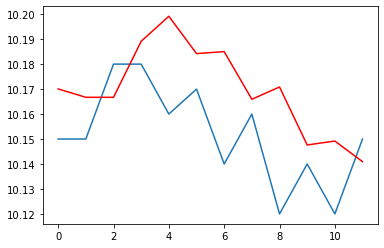

In [78]:
# create and evaluate an updated autoregressive model
# split dataset
X = series.values
train, test = X[0:len(X)-12], X[len(X)-12:]
# train autoregression
window = 2
model = AutoReg(train, lags=modelp.ar_lags,old_names=False)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()